# Battery energy storage system (BESS) 

https://medium.com/@yeap0022/basic-build-optimization-model-to-schedule-batterys-operation-in-power-grid-systems-51a8c04b3a0e

In [152]:
import pandas as pd
import datetime
import os
import timeit
from ortools.linear_solver import pywraplp


import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

## Reading data

In [153]:
# Read Excel file
file_name = os.fsdecode("data/data.xlsx")
workbook = pd.ExcelFile(file_name)

output_folder = "data/output"
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)

# Load timeseries data
marketDF = workbook.parse("Timeseries data")
marketDF = marketDF.iloc[:,:5]
marketDF.columns = ["time", "market_price_1", "load", "wind", "solar"]
marketDF = marketDF[~pd.isnull(marketDF["time"])].fillna(0)

market1DF = marketDF.copy()
market1DF.sort_values(by=["time"], inplace=True)
market1DF["time_string"] = market1DF.apply(lambda x:(x["time"]+ datetime.timedelta(seconds=0.002)).strftime("%d/%m/%Y %H:%M"), axis=1)
market1DF.set_index("time_string", inplace=True)
marketDF = market1DF

# Load static data
gridDF = workbook.parse("Grid")
gridDF = gridDF.iloc[:,:4]
gridDF.columns = ["max_buy_power", "max_sell_power", "max_import_power", "max_export_power"]

# Load battery data
battDF = workbook.parse("Battery")
battDF = battDF.iloc[:,:8]
battDF.columns = ["max_charge_rate", "max_discharge_rate", "capacity", "charge_eff", "discharge_eff", "min_soc", "max_soc", "initial_soc"]

# Convert dataframe to dictionary
marketDict = marketDF.to_dict()
gridDict = gridDF.to_dict()
battDict = battDF.to_dict()

timeInterval = marketDF.iloc[1]["time"] - marketDF.iloc[0]["time"]

# Assign the data to right places
input = type("input", (dict,), {})()
input.update({
    "simData": {
        "startTime": datetime.datetime.strptime(marketDF.index[0], "%d/%m/%Y %H:%M"),
        "dt": int(round(timeInterval.total_seconds())) / (60 * 60), #in hour
        "tIndex": marketDF.shape[0]
        },
    "market": {
        key: {
            sub_key: sub_item for sub_key, sub_item in marketDict[key].items()
            } for key in marketDict.keys() if key != "time"
        },
    "grid": {
        key: item[0] for key, item in gridDict.items()
        },
    "batt": {
        key: item[0] for key, item in battDict.items()
        }
    })

In [154]:
battDF

,max_charge_rate,max_discharge_rate,capacity,charge_eff,discharge_eff,min_soc,max_soc,initial_soc
0,2000,2000,4000,0.05,0.05,0.1,0.95,0.5


In [155]:
gridDF

,max_buy_power,max_sell_power,max_import_power,max_export_power
0,99999,99999,99999,99999


In [156]:
marketDF

,time,market_price_1,load,wind,solar
time_string,,,,,
01/01/2018 00:00,2018-01-01 00:00:00,48.47,12753.0,10715.50,0.01520
01/01/2018 00:30,2018-01-01 00:30:00,49.81,13133.5,10650.50,0.00851
01/01/2018 01:00,2018-01-01 01:00:00,53.65,13061.0,10560.00,0.00190
01/01/2018 01:30,2018-01-01 01:30:00,52.48,12576.0,10497.00,0.00390
01/01/2018 02:00,2018-01-01 02:00:00,47.25,12146.0,10464.00,0.00190
01/01/2018 02:30,2018-01-01 02:30:00,47.18,11841.5,10430.00,0.00380
01/01/2018 03:00,2018-01-01 03:00:00,40.24,11430.0,10358.75,0.00585
01/01/2018 03:30,2018-01-01 03:30:00,38.56,8569.5,11301.50,0.00607
01/01/2018 04:00,2018-01-01 04:00:00,37.55,8609.5,11208.50,0.01030


## Mixed Integer Programming Solver

In [157]:
# Create the mip solver with the CBC backend.
solver = pywraplp.Solver.CreateSolver("CBC")

inf = solver.infinity()

In [158]:
tIndex = input["simData"]["tIndex"] # number of timeslots
dt = input["simData"]["dt"] # time interval in hour

# Create datetime array
startTime = input["simData"]["startTime"].strftime("%d/%m/%Y %H:%M")
tIndex = input["simData"]["tIndex"]
timestamp = pd.date_range(startTime, periods=tIndex, freq=str(dt * 60) + "min")
time = [timestamp[i].strftime("%d/%m/%Y %H:%M") for i in range(len(timestamp))]

In [159]:
time_s = timeit.default_timer()
# Add timeseries variables
vGrid = [solver.NumVar(lb=-inf, ub=inf, name="") for _ in range(tIndex)]

vBattPower = [solver.NumVar(lb=-inf, ub=inf, name="") for _ in range(tIndex)]
vCharge = [solver.NumVar(lb=-inf, ub=0, name="") for _ in range(tIndex)]
vDischarge = [solver.NumVar(lb=0, ub=inf, name="") for _ in range(tIndex)]
vChargeStatus = [solver.BoolVar(name="") for _ in range(tIndex)]
vSOC = [solver.NumVar(lb=0, ub=1, name="") for _ in range(tIndex)]

In [160]:
# Add constraints
for i in range(tIndex):
    
    t = time[i]
    
    # Grid constraints
    solver.Add(vGrid[i] == input["market"]["load"][t] - input["market"]["solar"][t] - input["market"]["wind"][t] - vBattPower[i]) # Eqn. 1
    solver.Add(vGrid[i] <= input["grid"]["max_buy_power"]) # Eqn. 2
    solver.Add(vGrid[i] >= -input["grid"]["max_sell_power"]) # Eqn. 2
    solver.Add(input["market"]["load"][t] - input["market"]["solar"][t] - input["market"]["wind"][t] + vDischarge[i] + vCharge[i] <= input["grid"]["max_import_power"]) # Eqn. 3
    solver.Add(input["market"]["load"][t] - input["market"]["solar"][t] - input["market"]["wind"][t] + vDischarge[i] + vCharge[i] >= -input["grid"]["max_export_power"]) # Eqn. 3
    
    # Battery constraints
    solver.Add(vBattPower[i] == vCharge[i] + vDischarge[i]) # Eqn. 4
    solver.Add(vCharge[i] >= -input["batt"]["max_charge_rate"] * vChargeStatus[i]) # Eqn. 5(a)
    solver.Add(vDischarge[i] <= input["batt"]["max_discharge_rate"] * (1-vChargeStatus[i])) # Eqn. 5(b)
    
    if i == 0:
        solver.Add(vSOC[i] == input["batt"]["initial_soc"] - dt / input["batt"]["capacity"] * (vCharge[i] * (1-input["batt"]["charge_eff"]) + vDischarge[i] / (1-input["batt"]["discharge_eff"]))) # Eqn. 6
    else:
        solver.Add(vSOC[i] == vSOC[i-1] - dt / input["batt"]["capacity"] * (vCharge[i] * (1-input["batt"]["charge_eff"]) + vDischarge[i] / (1-input["batt"]["discharge_eff"]))) # Eqn. 6
        
    solver.Add(vSOC[i] >= input["batt"]["min_soc"]) # Eqn. 7
    solver.Add(vSOC[i] <= input["batt"]["max_soc"]) # Eqn. 7

In [161]:
# Add objective
obj = 0
obj += sum([vGrid[i] * input["market"]["market_price_1"][time[i]] * dt for i in range(tIndex)])
solver.Minimize(obj)

## Solve the Optimization Problem

In [162]:
status = solver.Solve()

time_e = timeit.default_timer()
runTime = round(time_e - time_s, 4)

In [163]:
if status == solver.OPTIMAL or status == solver.FEASIBLE:
    print("Solution is found.")
    print("Number of variables =", solver.NumVariables())
    print("Number of constraints =", solver.NumConstraints())
    print("Computation time = ", runTime)
    
    # Extract solution values
    excelWriter = pd.ExcelWriter('data/output/Result.xlsx', engine='xlsxwriter')
    
    objValue = round(solver.Objective().Value() / 100, 2)
    
    objValueDF = pd.DataFrame.from_dict({"obj_value": objValue}, orient="index", columns=["Total Cost of Importing Power ($)"])
    
    result = list(zip([round(vGrid[i].solution_value(), 4) for i in range(tIndex)], 
                      [round(vBattPower[i].solution_value(), 4) for i in range(tIndex)],
                      [round(vCharge[i].solution_value(), 4) for i in range(tIndex)],
                      [round(vDischarge[i].solution_value(), 4) for i in range(tIndex)],
                      [round(vSOC[i].solution_value(), 4) for i in range(tIndex)],
                      [int(vChargeStatus[i].solution_value()) for i in range(tIndex)]
                      ))
    resultDF = pd.DataFrame(result, index=time, columns=["Grid Power Flow (kW)", "Battery Output (kW)", "Charging Power (kW)", "Discharging Power (kW)", "State-of-charge (SOC)", "Charge Status"])
    
    objValueDF.to_excel(excelWriter, sheet_name='Cost')
    resultDF.to_excel(excelWriter, sheet_name='Operation')
    excelWriter.close()
else:
    print("Solution cannot be found.")

Solution is found.
Number of variables = 288
Number of constraints = 528
Computation time =  0.0312


In [164]:
market =marketDF[['market_price_1',	'load',	'wind','solar']]

In [165]:
market = market.rename(columns = {'market_price_1':'market_price'})
market['green'] = market['wind']+market['solar']
market.head(5)

,market_price,load,wind,solar,green
time_string,,,,,
01/01/2018 00:00,48.47,12753.0,10715.5,0.01520,10715.51520
01/01/2018 00:30,49.81,13133.5,10650.5,0.00851,10650.50851
01/01/2018 01:00,53.65,13061.0,10560.0,0.00190,10560.00190
01/01/2018 01:30,52.48,12576.0,10497.0,0.00390,10497.00390
01/01/2018 02:00,47.25,12146.0,10464.0,0.00190,10464.00190


In [166]:
# Read Excel file
file_name = os.fsdecode("data/output/Result.xlsx")
workbook = pd.ExcelFile(file_name)

operations = workbook.parse("Operation")
operations = operations.rename(columns = {'Unnamed: 0':'time_string'})
operations.set_index('time_string', inplace=True)
operations = operations.join(market)
operations.head(5)

,Grid Power Flow (kW),Battery Output (kW),Charging Power (kW),Discharging Power (kW),State-of-charge (SOC),Charge Status,market_price,load,wind,solar,green
time_string,,,,,,,,,,,
01/01/2018 00:00,2037.4848,0.0,0.0,0,0.5000,0,48.47,12753.0,10715.5,0.01520,10715.51520
01/01/2018 00:30,2482.9915,0.0,0.0,0,0.5000,0,49.81,13133.5,10650.5,0.00851,10650.50851
01/01/2018 01:00,500.9981,2000.0,0.0,2000,0.2368,0,53.65,13061.0,10560.0,0.00190,10560.00190
01/01/2018 01:30,1038.9961,1040.0,0.0,1040,0.1000,0,52.48,12576.0,10497.0,0.00390,10497.00390
01/01/2018 02:00,1681.9981,0.0,0.0,0,0.1000,0,47.25,12146.0,10464.0,0.00190,10464.00190


In [167]:
operations.head()

,Grid Power Flow (kW),Battery Output (kW),Charging Power (kW),Discharging Power (kW),State-of-charge (SOC),Charge Status,market_price,load,wind,solar,green
time_string,,,,,,,,,,,
01/01/2018 00:00,2037.4848,0.0,0.0,0,0.5000,0,48.47,12753.0,10715.5,0.01520,10715.51520
01/01/2018 00:30,2482.9915,0.0,0.0,0,0.5000,0,49.81,13133.5,10650.5,0.00851,10650.50851
01/01/2018 01:00,500.9981,2000.0,0.0,2000,0.2368,0,53.65,13061.0,10560.0,0.00190,10560.00190
01/01/2018 01:30,1038.9961,1040.0,0.0,1040,0.1000,0,52.48,12576.0,10497.0,0.00390,10497.00390
01/01/2018 02:00,1681.9981,0.0,0.0,0,0.1000,0,47.25,12146.0,10464.0,0.00190,10464.00190


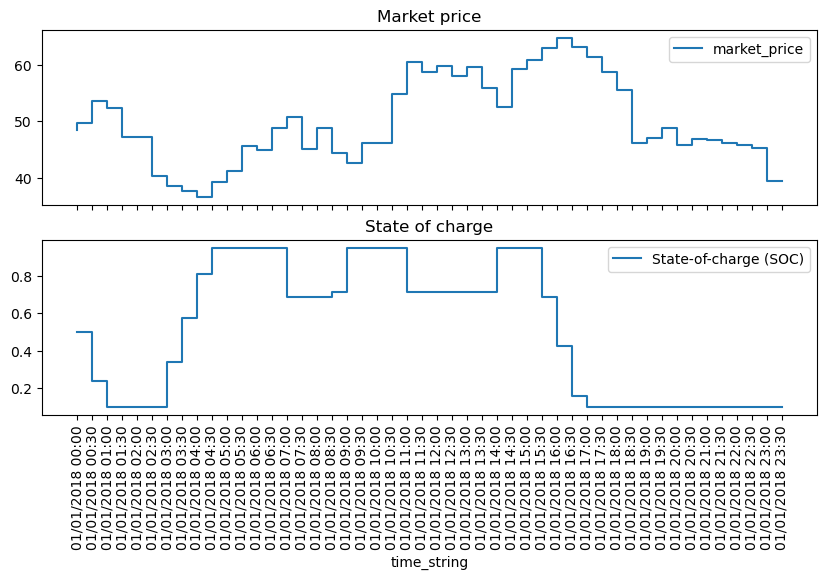

In [168]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
sns.lineplot(data = operations[['market_price']], drawstyle='steps-pre', ax=ax[0])
ax[0].set_title("Market price")
ax[0].set(xticklabels=[])
ax[0].set(xlabel=None)

sns.lineplot(data = operations[['State-of-charge (SOC)']],  drawstyle='steps-pre',ax=ax[1])
ax[1].set_title("State of charge")
ax[1].tick_params(axis='x', rotation=90)
plt.show()

In [169]:
operations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 01/01/2018 00:00 to 01/01/2018 23:30
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Grid Power Flow (kW)    48 non-null     float64
 1   Battery Output (kW)     48 non-null     float64
 2   Charging Power (kW)     48 non-null     float64
 3   Discharging Power (kW)  48 non-null     int64  
 4   State-of-charge (SOC)   48 non-null     float64
 5   Charge Status           48 non-null     int64  
 6   market_price            48 non-null     float64
 7   load                    48 non-null     float64
 8   wind                    48 non-null     float64
 9   solar                   48 non-null     float64
 10  green                   48 non-null     float64
dtypes: float64(9), int64(2)
memory usage: 5.5+ KB


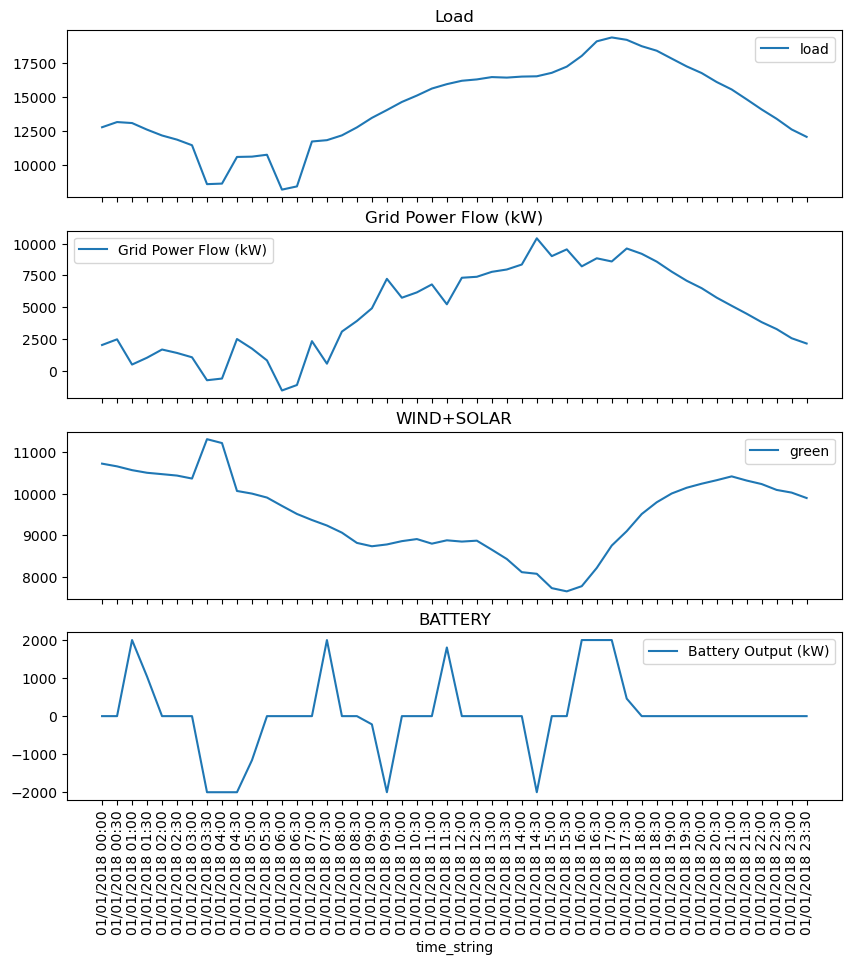

In [170]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

sns.lineplot(data = operations[['load']],  ax=ax[0])
ax[0].set_title("Load")
ax[0].set(xticklabels=[])
ax[0].set(xlabel=None)


sns.lineplot(data = operations[['Grid Power Flow (kW)']],  ax=ax[1])
ax[1].set_title("Grid Power Flow (kW)")
ax[1].set(xticklabels=[])
ax[1].set(xlabel=None)

sns.lineplot(data = operations[['green']],  ax=ax[2])
ax[2].set_title("WIND+SOLAR")
ax[2].set(xticklabels=[])
ax[2].set(xlabel=None)

sns.lineplot(data = operations[['Battery Output (kW)']],  ax=ax[3])
ax[3].set_title("BATTERY")
ax[3].tick_params(axis='x', rotation=90)
plt.show()